In [1]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=ac2923a0972e08408ccd5518e5c1d129ec92dc624b2c0ef9b934177f0524c897
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
!pip install pandas==1.1.5

In [2]:
import pandas as pd
import datetime as dt
import re
import pandasql as ps #SQL on Pandas Dataframe
import nltk
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from collections import Counter
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Three datasets we're using
! wget -nc https://storage.googleapis.com/penn-cis545/rotten_tomatoes_movies.csv
! wget -nc https://storage.googleapis.com/penn-cis545/rotten_tomatoes_critic_reviews.csv
! wget -nc https://storage.googleapis.com/penn-cis545/MoviesOnStreamingPlatforms.csv

--2022-03-29 18:22:47--  https://storage.googleapis.com/penn-cis545/rotten_tomatoes_movies.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17229548 (16M) [text/csv]
Saving to: ‘rotten_tomatoes_movies.csv’

rotten_tomatoes_mov 100%[===================>]  16.43M  --.-KB/s    in 0.1s    

2022-03-29 18:22:47 (114 MB/s) - ‘rotten_tomatoes_movies.csv’ saved [17229548/17229548]

--2022-03-29 18:22:47--  https://storage.googleapis.com/penn-cis545/rotten_tomatoes_critic_reviews.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226049903 (216M) [text/csv]
Saving 

In [5]:
print(pd.__version__)
# Make sure it's 1.1.5

1.3.5


## Part 1: Load & Process our Datasets

Before we get into the data, we first need to load and clean our datasets. 

* Load and save the `rotten_tomatoes_movies.csv` to a dataframe called `movies_df`.
* Load and save the `rotten_tomatoes_critic_reviews.csv` to a dataframe called `reviews_df`.
* Load and save the `MoviesOnStreamingPlatforms.csv` to a dataframe called `streaming_df` without the index column being included.

In [6]:
# Import the datasets to pandas dataframes
movies_df = pd.read_csv("rotten_tomatoes_movies.csv")
reviews_df = pd.read_csv("rotten_tomatoes_critic_reviews.csv")
streaming_df =  pd.read_csv("MoviesOnStreamingPlatforms.csv")

In [7]:
# view movies_df to make sure the import was successful
movies_df.head(2)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,runtime,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,90.0,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,123,19


In [8]:
# view reviews_df to make sure the import was successful
reviews_df.head(2)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."


In [9]:
# view streaming_df to make sure the import was successful
streaming_df.head(2)

,Unnamed: 0,ID,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,1,2,Dangal,2016,7+,97/100,1,0,0,0,0


### 1.1 Data Preprocessing

Next, we are going to want to clean up our dataframes by 1) fixing column names, 2) changing datatypes, 3) cleaning text, and 4) handling nulls.

First, let's do EDA
.

In [10]:
# view info information regarding movies_df
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [11]:
# clean movies_df
movies_df = movies_df.drop(columns=['critics_consensus','production_company'])
movies_df['genres'] = movies_df['genres'].fillna("No Genre")
movies_df = movies_df.dropna(axis=0)
movies_df["original_release_date"] = pd.to_datetime(movies_df["original_release_date"],unit='ns')
movies_df['streaming_release_date'] = pd.to_datetime(movies_df['streaming_release_date'],unit='ns')
movies_df['runtime'] = movies_df['runtime'].astype('int64')
movies_df['tomatometer_count'] = movies_df['tomatometer_count'].astype('int64')
movies_df['tomatometer_rating'] = movies_df['tomatometer_rating'].astype('int64')
movies_df['audience_count'] = movies_df['audience_count'].astype('int64')
movies_df['audience_rating'] = movies_df['audience_rating'].astype('int64')

In [12]:
# create new dataframe and genre column
exploded_movies_df = movies_df
exploded_movies_df['genre']=exploded_movies_df['genres'].str.split(',')
exploded_movies_df = exploded_movies_df.explode('genre')
exploded_movies_df['genre']=exploded_movies_df['genre'].apply(lambda x: x.strip(" "))

In [13]:
#view info of reviews_df
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


In [14]:
#Clean reviews_df
reviews_df = reviews_df.dropna(subset=['review_score','review_content'],axis = 0)
reviews_df['critic_name'] = reviews_df['critic_name'].fillna("Anonymous")
reviews_df['review_date']=pd.to_datetime(reviews_df['review_date'],unit='ns')

In [15]:
# more EDA here!
reviews_df.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
count,758709,758709,758709,758709,758709,758709,758709,758709
unique,17624,6842,2,1626,2,813,7475,677125
top,m/star_wars_the_rise_of_skywalker,Dennis Schwartz,False,eFilmCritic.com,Fresh,3/5,2000-01-01 00:00:00,full review at Movies for the Masses
freq,672,6488,580572,8550,484127,76972,22465,199
first,NaN,NaN,NaN,NaN,NaN,NaN,1800-01-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-29 00:00:00,NaN


In [16]:
reviews_df['critic_name'].unique()

array(['Ben McEachen', 'Nick Schager', 'Bill Goodykoontz', ...,
       'Linda McGee', 'Jerry Bokamper', 'Tom Mansell'], dtype=object)

## Part 2: Exploring the Data with PandasSQL and Pandas




###2.1 Movie Recommendations

#### 2.1.1 What movies have good reviews from critics and audience?

`movies_df` contains all sorts of movies. We all love good movies, so let's try to separate the good from the bad.


In [17]:
# Use pandas to obtain good_critics_df
good_critics_df = movies_df[(movies_df['tomatometer_status']=="Certified-Fresh") | (movies_df['tomatometer_status']=="Fresh")]
good_critics_df = good_critics_df[["rotten_tomatoes_link","movie_title"]]

then, let's consider the ratings by movie-goers.


In [18]:
movies_df = movies_df.drop(columns=['genre'])

In [20]:
# Use pandasql to obtain movies with good audience rating
good_audience_query = """SELECT rotten_tomatoes_link, movie_title
FROM movies_df
WHERE audience_status = 'Upright'
"""

good_audience_df = ps.sqldf(good_audience_query,locals())

Now, we can simply join these dataframes to get a table of all the best movies and binge watch one every night! But wait! Sometimes, the opinions of critics and audience may differ, so we need to make sure that the good movies we watch are ones that are viewed positively by both critics and audiences. 

Thus, we use **pandas and pandasql** to filter out movies with **mixed reviews** (ie. audience and critic opinions differ) to a new dataframe `pd/sql_mixed_movies_df`, ordered by lexicographic order of `movie_title`.

In [21]:
import numpy as np

In [23]:
# Filter out movies with mixed reviews using pandas
pd_mixed_movies_df = good_critics_df.merge(good_audience_df,how='outer',on=['rotten_tomatoes_link'],indicator=True)
pd_mixed_movies_df = pd_mixed_movies_df[pd_mixed_movies_df["_merge"] != "both"]
pd_mixed_movies_df = pd_mixed_movies_df.rename(columns={'movie_title_x': 'movie_title'})
pd_mixed_movies_df['movie_title'] = np.where(pd_mixed_movies_df["_merge"] == "right_only",pd_mixed_movies_df["movie_title_y"],pd_mixed_movies_df['movie_title'])
pd_mixed_movies_df = pd_mixed_movies_df.drop(['_merge','movie_title_y'],axis=1)
pd_mixed_movies_df = pd_mixed_movies_df.sort_values(by='movie_title')
pd_mixed_movies_df

,rotten_tomatoes_link,movie_title
2584,m/dollars,$ (Dollars) (The Heist)
998,m/999_2008,$9.99
5460,m/r-xmas,'R Xmas
8123,m/1_night,1 Night (One Night)
1,m/10,10
...,...,...
9625,m/zulu_dawn,Zulu Dawn
5521,m/rec_4_apocalypse,[REC] 4: Apocalypse
1963,m/bwoy,bwoy
3678,m/iboy,iBoy


In [24]:
# Filter out movies with mixed reviews from good_critics_df and good_audience_df
mixed_query = """
SELECT rotten_tomatoes_link, movie_title 
FROM 
  (
    SELECT rotten_tomatoes_link, movie_title FROM good_critics_df
    EXCEPT SELECT rotten_tomatoes_link, movie_title FROM good_audience_df
  ) 
UNION 
SELECT rotten_tomatoes_link, movie_title 
FROM 
  (
    SELECT rotten_tomatoes_link, movie_title FROM good_audience_df
    EXCEPT SELECT rotten_tomatoes_link, movie_title FROM good_critics_df
  ) 
ORDER BY movie_title ASC
"""
#https://www.red-gate.com/simple-talk/databases/sql-server/performance-sql-server/the-except-and-intersect-operators-in-sql-server/
sql_mixed_movies_df = ps.sqldf(mixed_query,locals())
sql_mixed_movies_df

,rotten_tomatoes_link,movie_title
0,m/dollars,$ (Dollars) (The Heist)
1,m/999_2008,$9.99
2,m/r-xmas,'R Xmas
3,m/1_night,1 Night (One Night)
4,m/10,10
...,...,...
3545,m/zulu_dawn,Zulu Dawn
3546,m/rec_4_apocalypse,[REC] 4: Apocalypse
3547,m/bwoy,bwoy
3548,m/iboy,iBoy


**TODO:**

Using **pandas/pandasql** and `pd/sql_mixed_movies_df`, find the top 10 mixed movies with the **largest absolute difference** in critic review score and audience review score. You should calculate this as the absolute difference between `tomatometer_rating` and `audience_rating`, and store this in a column named `diff`. If multiple movies have the same `diff` value, order their rows in lexicographic order.

Format the output as a dataframe called `pd/sql_top_10_mixed_movies_df` that has the following schema:

>movie_title | diff
>--- | ---


In [25]:
# TODO: pandas
df_diff = pd_mixed_movies_df.merge(movies_df,how='left',on=['rotten_tomatoes_link','movie_title'])
df_diff['diff'] = np.abs(df_diff['tomatometer_rating'] - df_diff['audience_rating'])
df_diff = df_diff.sort_values(by=['diff','movie_title'],ascending=[False,True])
pd_top_10_mixed_movies_df = df_diff[['movie_title','diff']].head(10)

In [26]:
#TODO: pandasql
top_10_mixed_query = """
SELECT movie_title, Abs(tomatometer_rating - audience_rating) AS diff
FROM(
SELECT sql_mixed_movies_df.movie_title, movies_df.tomatometer_rating, audience_rating
FROM sql_mixed_movies_df
LEFT JOIN movies_df
ON sql_mixed_movies_df.rotten_tomatoes_link = movies_df.rotten_tomatoes_link)
ORDER BY diff DESC, movie_title ASC
LIMIT 10
"""

sql_top_10_mixed_movies_df = ps.sqldf(top_10_mixed_query,locals())
#https://www.tutorialspoint.com/sorted-difference-between-two-columns-in-mysql

#### 2.1.2 Horror Movie recommendation

Are there more horror movies during October (because of Halloween)? 


In [27]:
# pandas version
movies_df['month']= movies_df['original_release_date'].apply(lambda x: x.month)
df_horror = movies_df[movies_df['genres'].str.contains('Horror')]
pd_horror_df = df_horror.groupby('month',as_index=False).count()
#pd_horror_df = pd.DataFrame({'num_movies' : movies_df.groupby('month',as_index=False).count()}).reset_index()
pd_horror_df = pd_horror_df[['month','rotten_tomatoes_link']]
pd_horror_df = pd_horror_df.rename(columns={'rotten_tomatoes_link':'num_movies'})
pd_horror_df = pd_horror_df.sort_values(by=['num_movies'],ascending=False)
pd_horror_df

,month,num_movies
0,1,230
9,10,209
8,9,160
7,8,152
3,4,143
5,6,143
2,3,133
1,2,113
6,7,107
4,5,105


In [28]:
# pandasql version
horror_query = """
SELECT month, COUNT(rotten_tomatoes_link) AS num_movies
FROM(
  SELECT *
FROM movies_df M
WHERE M.genres LIKE '%Horror%')
GROUP BY month
ORDER BY num_movies DESC
"""

sql_horror_df = ps.sqldf(horror_query,locals())
sql_horror_df

,month,num_movies
0,1,230
1,10,209
2,9,160
3,8,152
4,4,143
5,6,143
6,3,133
7,2,113
8,7,107
9,5,105


It seems like October is not the most popular month in which horror movies are released. 

Then, let's find the movies classified as `Horror` that were originally released in **January**.

In [30]:
# pandas version
df_horror = movies_df[movies_df['genres'].str.contains('Horror')]
df_horror_jan = df_horror[df_horror['month']==1]
pd_jan_df = df_horror_jan[['rotten_tomatoes_link','movie_title','audience_count']]
pd_jan_df = pd_jan_df.sort_values(by='audience_count',ascending=False)

In [34]:
# pandasql version
jan_query = """
SELECT rotten_tomatoes_link, movie_title, audience_count
FROM(
  SELECT *
FROM movies_df M
WHERE M.genres LIKE '%Horror%')
WHERE month = 1
ORDER BY audience_count DESC
"""

sql_jan_df = ps.sqldf(jan_query,locals())
sql_jan_df

,rotten_tomatoes_link,movie_title,audience_count
0,m/10010150-unborn,The Unborn,831848
1,m/uninvited_2009,The Uninvited,659265
2,m/hostel,Hostel,471115
3,m/final_destination_2,Final Destination 2,449641
4,m/hitcher,The Hitcher,422249
...,...,...,...
225,m/inside_2018,Inside,99
226,m/big_muddy_2011,Big Muddy,75
227,m/delirium_2018,Delirium,72
228,m/the_host_2020,The Host,51


With all the information about these movies, we are ready to make movie recommendations. In particular, let's find a movie that: 
- is a horror movie
- was originally released in January 
- has been watched by at least 50000 audience members, with an overall `audience_rating` of `Upright`.  

In [35]:
# use pandasql to find top 10 movies that fit criteria
recs_query = """
SELECT rotten_tomatoes_link, movie_title, audience_count
FROM
(SELECT *
 FROM pd_jan_df P INNER JOIN good_audience_df G
 ON P.rotten_tomatoes_link = G.rotten_tomatoes_link)
ORDER BY audience_count DESC
LIMIT 10
"""

movie_recs_df = ps.sqldf(recs_query,locals())
movie_recs_df

,rotten_tomatoes_link,movie_title,audience_count
0,m/phantom_of_the_opera,The Phantom of the Opera,412132
1,m/from_dusk_till_dawn,From Dusk Till Dawn,273797
2,m/tremors,Tremors,240153
3,m/underworld_rise_of_the_lycans,Underworld: The Rise of the Lycans,232651
4,m/evil_dead_2_dead_by_dawn,Evil Dead 2: Dead by Dawn,148402
5,m/underworld_awakening,Underworld: Awakening,98541
6,m/1011615-king_kong,King Kong,90136
7,m/not_easily_broken,Not Easily Broken,69412
8,m/let_the_right_one_in,Let the Right One In,61368
9,m/eraserhead,Eraserhead,57526


### 2.2 Good Critic Reviews 

Now let us switch gears and find the critics who are good at writing reviews.

The first criteria that defines a good reviewer is balance and objectivity. Just like people (other than me), no movie is perfect, and so we probably want reviews to cover both the good and the bad. 

Therefore, by using `reviews_df` and **pandasql**, we can find the reviews that contain both the word `"good"` and the word `"bad"` (case-insensitive). Include substrings (ie. it can be part of a word, such as '**good**-natured' or 'for**bad**e').


In [36]:
# use pandasql to find reviews with both words "good" and "bad"
balanced_query = """
SELECT critic_name, review_content
FROM reviews_df R
WHERE (LOWER(R.review_content) LIKE '%good%' 
AND LOWER(R.review_content) LIKE '%bad%')
ORDER BY R.review_content ASC
"""
balanced_df = ps.sqldf(balanced_query,locals())
balanced_df.head()
#https://www.w3schools.com/sql/sql_wildcards.asp

,critic_name,review_content
0,Mick LaSalle,"""A United Kingdom"" features committed performa..."
1,Chris Hewitt,"""Act of Valor"" looks a good deal like a war-th..."
2,Adam Graham,"""Alexander"" won't change your day, but it's no..."
3,Robin Clifford,"""Bad"" is the operative word for ""Bad Company,""..."
4,Brent McKnight,"""Brick Mansions"" isn't a good movie, but it is..."


*Good cause, bad movie.* One of my favourite quotes.

The second criteria we have for good critics is tenure. Let us find the "seasoned" reviewers, ie. those who have been writing reviews for a long period of time.

By using `reviews_df` and **pandasql**, we
- Create a column `date_diff` which contains the difference (in number of days) between each critic's first review and most recent review
- Only include reviews from the 21st Century (ie. published from 2000 onward)
- Only include critics whose first and most recent reviews are at least 10 years **(3652 days)** apart
- Do not include reviews by `'Anonymous'`


In [37]:
# use pandasql to find seasoned reviewers
time_query = """
SELECT critic_name, CAST(julianday(MAX(review_date))-julianday(MIN(review_date)) AS Integer) AS date_diff
FROM  reviews_df
WHERE (critic_name != 'Anonymous' AND strftime('%Y', review_date) >= '2000')
GROUP BY critic_name
HAVING date_diff >= 3652
ORDER BY date_diff DESC
"""

critics_time_df = ps.sqldf(time_query,locals())
critics_time_df.head(5)
#https://www.sqlite.org/lang_datefunc.html

,critic_name,date_diff
0,Frederic and Mary Ann Brussat,7604
1,Jo Berry,7604
2,Empire Staff,7601
3,Randall King,7601
4,David Nusair,7599


### 2.3 What do we watch on Netflix tonight?

Now let's run a tougher analysis. We've all experienced the aimless scrolling through the Netflix homepage, trying (and sometimes failing) to find a movie that interests us. It's painful to manually search up the reviews of each movie we see, so why don't we try to automate this process? Let's determine the best on Netflix for each genre using both critics' and audiences' opinions on Rotten Tomatoes.

In [38]:
# use pandasql to find the best on Netflix
netflix_best_query = """
WITH TB AS
(
SELECT genre_category, combined_rt_rating 
FROM (
SELECT Title AS movie_title, genres, genre AS genre_category, max(combined_rt_rating) AS combined_rt_rating 
FROM(
  SELECT s.Title, e.genres, e.genre, e.tomatometer_rating + e.audience_rating AS combined_rt_rating
FROM streaming_df s LEFT JOIN exploded_movies_df e 
ON s.Title = e.movie_title
WHERE s.Netflix = 1)
GROUP BY genre_category
))

SELECT e.movie_title, e.genres, e.genre AS genre_category, e.tomatometer_rating + e.audience_rating AS combined_rt_rating 
FROM exploded_movies_df e JOIN streaming_df s
ON s.Title = e.movie_title
WHERE s.Netflix = 1 AND (genre_category, combined_rt_rating) IN TB
ORDER BY genre_category
"""

netflix_best_df = ps.sqldf(netflix_best_query,locals())
netflix_best_df

,movie_title,genres,genre_category,combined_rt_rating
0,Terminator 2: Judgment Day,"Action & Adventure, Drama, Science Fiction & F...",Action & Adventure,187
1,Hunt for the Wilderpeople,"Action & Adventure, Comedy",Action & Adventure,187
2,Klaus,"Animation, Comedy, Kids & Family, Science Fict...",Animation,191
3,Mirai,"Animation, Anime & Manga, Art House & Internat...",Anime & Manga,170
4,Maktub,"Art House & International, Comedy, Drama",Art House & International,199
5,Chinatown,"Classics, Drama, Mystery & Suspense",Classics,192
6,Maktub,"Art House & International, Comedy, Drama",Comedy,199
7,Mad Max,"Action & Adventure, Cult Movies, Science Ficti...",Cult Movies,160
8,The C Word,Documentary,Documentary,194
9,Maktub,"Art House & International, Comedy, Drama",Drama,199


### 2.4 Which months of the year does each streaming service have the most number of movies available?

Maybe you don't care about picking out the "good" movies from the "bad" ones. Maybe you just want to watch as many movies as possible each month. Still, paying those monthly bills for all these streaming services (which seem to be increasing in number every day) doesn't seem to be a sustainable strategy. It would be much easier to pay for certain streaming services in the month they have the most movies.

Thus, by using `movies_df` and `streaming_df`, we can
- Count the number of movies for each streaming service per month using the `month` column in `movies_df` you created earlier.
- For each streaming service, find the month in which they have the most movies available and how many movies are available in that month. Include ties, if there are any.

In [39]:
#  use pandasql to find the month where each streaming service has the most movies
best_streaming_query = """
WITH titles AS (
  SELECT * 
  FROM movies_df m INNER JOIN streaming_df s ON m.movie_title = s.Title
  ),

  net AS( SELECT 'Netflix' as streaming_service, a.month, count(*) AS count 
  FROM titles a 
  WHERE a.Netflix = 1 
  GROUP BY a.month
  ),

  hulu AS(SELECT 'Hulu' as streaming_service, a.month, count(*) AS count 
  FROM titles a 
  WHERE a.Hulu = 1 
  GROUP BY a.month
  ),

  prime AS(SELECT 'Prime Video' as streaming_service, a.month, count(*) AS count 
  FROM titles a 
  WHERE a.[Prime Video] = 1 
  GROUP BY a.month
  ),

  disney AS(SELECT 'Disney+' as streaming_service, a.month, count(*) AS count 
  FROM titles a 
  WHERE a.[Disney+] = 1 
  GROUP BY a.month
  )

SELECT streaming_service, month AS max_month, max(count) AS num_movies 
FROM (
  SELECT * FROM net
  UNION ALL 
  SELECT * FROM hulu
  UNION ALL 
  SELECT * FROM prime
  UNION ALL 
  SELECT * FROM disney
)
GROUP BY streaming_service
"""

best_streaming_df = ps.sqldf(best_streaming_query,locals())
best_streaming_df

,streaming_service,max_month,num_movies
0,Disney+,6,44
1,Hulu,8,65
2,Netflix,10,92
3,Prime Video,9,126


### 2.5 What movies are underrated by critics (ft. top critics)?

[According to the Rotten Tomatoes website](https://www.rottentomatoes.com/critics/top_critics), "Top Critic is a designation created to distinguish Tomatometer-approved critics who excel at their craft. Critics selected are well-established, influential, and prolific..." Although all critics on RT are officially approved, we want to establish a top-critic-only score that only includes the opinions of the "cream of the crop". Certain films could be poorly received by regular critics, but top critics see something special in them. Let's try and find these underappreciated movies!

In [40]:
# use pandasql to find the regular critics' underrated movies
underrated_movies_query = """
WITH fresh_tb AS (
  SELECT m.rotten_tomatoes_link, COUNT(*) AS f_count 
  FROM reviews_df r JOIN movies_df m ON r.rotten_tomatoes_link = m.rotten_tomatoes_link
  WHERE (r.top_critic = 1 AND r.review_type = 'Fresh')
  GROUP BY m.rotten_tomatoes_link
), 
total_tb AS (
  SELECT m.rotten_tomatoes_link, COUNT(*) AS t_count 
  FROM reviews_df r JOIN movies_df m ON r.rotten_tomatoes_link = m.rotten_tomatoes_link
  WHERE (r.top_critic = 1)
  GROUP BY m.rotten_tomatoes_link 
  HAVING COUNT(*) > 5
), 
tct AS (
  SELECT f.rotten_tomatoes_link, CAST(CAST(f.f_count AS float) / CAST(t.t_count AS float) * 100 AS Int) AS top_critic_tomatometer 
  FROM fresh_tb f JOIN total_tb t ON f.rotten_tomatoes_link = t.rotten_tomatoes_link
)

SELECT m.movie_title, tct.top_critic_tomatometer, m.tomatometer_rating, (top_critic_tomatometer - tomatometer_rating) AS score_diff 
FROM tct JOIN movies_df m ON tct.rotten_tomatoes_link = m.rotten_tomatoes_link
ORDER BY score_diff DESC 
LIMIT 10
"""

In [42]:
underrated_movies_df = ps.sqldf(underrated_movies_query,locals())
underrated_movies_df

,movie_title,top_critic_tomatometer,tomatometer_rating,score_diff
0,An Everlasting Piece,100,48,52
1,Sgt. Bilko,80,31,49
2,Cry_Wolf,66,24,42
3,Richie Rich,66,24,42
4,Supernova,50,10,40
5,Barney's Great Adventure,71,32,39
6,15 Minutes,69,32,37
7,Far From the Madding Crowd,100,64,36
8,Reality (Réalité),100,64,36
9,Down and Derby,57,22,35


## Part 3: Working with Text Data

Shifting gears, let's now try to do some text-based analysis. Text data is complex, but can also be used to generate extremely interpretable results, making it valuable and interesting. 

**How do reviews by top critics differ from reviews made by non-top critics?**


###3.1 Extract Data

In [43]:
# create two dataframes & two lists for top and regular critics
top_critics_df = reviews_df[reviews_df['top_critic']==True]
regular_critics_df = reviews_df[reviews_df['top_critic']==False]

top_content = list(top_critics_df['review_content'])
regular_content =list(regular_critics_df['review_content'])

###3.2 Tokenize the Text

Here, we are going to split up the content into a list of words. We will use the **nltk** package, which contains an extensive set of tools to process text. 

First, we use **stopwords** to create a set of the most common english stopwords. Then, we implement **tokenized_content(content)** that takes in a content string and:
1. tokenizes the text
2. lowercases the token
3. removes stop words (commonly used words such as "a","an", "in")
4. keeps words with only alphabet characters (no punctuation)

In [44]:
import nltk
nltk.__version__

'3.2.5'

In [45]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
# Note that stopwords are all in lowercase format

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [46]:
# Create tokenized_content(content) function
def tokenized_content(content):
  new_content = []
  for mytext in content:
    mytext = nltk.word_tokenize(mytext)
    for word in mytext:
      word = word.lower() 
      if word.isalpha():
        if not word in stopwords:
          new_content.append(word)
  return new_content

Now, apply  `tokenize_content()` function to each piece of content in **top_content** and **regular_content** and flatten both of the lists to create **top_tokens** and **regular_tokens**


In [47]:
# tokenize and flatten
top_tokens = tokenized_content(top_content)
#top_tokens = [item for sublist in top_tokens for item in sublist]

In [48]:
regular_tokens = tokenized_content(regular_content)

### 3.3 Most Frequent Words
Now, let's find the 20 most common words amongst the content of `top_tokens` and `regular_tokens`. Return this as a list of `(word, count)` tuples, in descending order of `count`.

In [49]:
# Find 20 most common words amongst the content of the top and regular critic reviews
top_most_common = Counter(top_tokens).most_common(20)
regular_most_common = Counter(regular_tokens).most_common(20)

In [50]:
print(top_most_common)
print(regular_most_common)

[('movie', 25293), ('film', 25125), ('like', 13750), ('one', 13749), ('story', 9291), ('even', 8014), ('much', 7793), ('good', 6925), ('comedy', 5822), ('way', 5812), ('time', 5552), ('make', 5508), ('director', 5479), ('never', 5463), ('little', 5286), ('us', 5023), ('enough', 4909), ('best', 4872), ('characters', 4820), ('makes', 4805)]
[('film', 96931), ('movie', 64478), ('one', 49483), ('like', 38145), ('story', 32736), ('good', 24693), ('much', 24008), ('even', 22702), ('best', 21011), ('time', 20092), ('comedy', 19321), ('make', 18345), ('great', 16673), ('characters', 16435), ('fun', 16339), ('little', 16169), ('way', 16072), ('enough', 15961), ('never', 15803), ('action', 15545)]


###3.4 Refining our Lists

Hmmm...both of these lists seem to display similar words. Let's try to tease out words that distinguish the high from the low scoring questions. 

One approach would be to find words in one list that are not in the other. This, however, may be too naive, as even if a word is extremely common in our high list, if it appears only once in our low list, it would get removed from consideration.

Let's instead find the difference between the counts within our two lists. Thus, if a word is really common in one, but not the other, the count would only decrease slightly. Alternatively, if a word is common in both lists, it would effectively zero out. 

However, given that the number of regular tokens is about three times that of top tokens, we need to make sure both lists are of equal length before applying the difference method. 

In [51]:
# randomly sample 1 million tokens from top_tokens and regular_tokens
import random
top_sample = Counter(random.sample(top_tokens,1000000))
regular_sample = Counter(random.sample(regular_tokens,1000000))

In [52]:
# use difference to find the top 20 counts of words within each group
distinct_top_most_common = (top_sample - regular_sample).most_common(20)
distinct_regular_most_common =(regular_sample - top_sample).most_common(20)

In [53]:
print(distinct_top_most_common)
print(distinct_regular_most_common)

[('movie', 2582), ('like', 1012), ('director', 658), ('even', 580), ('documentary', 413), ('seems', 412), ('us', 378), ('way', 369), ('kind', 364), ('something', 315), ('movies', 300), ('sometimes', 296), ('might', 292), ('often', 286), ('makes', 285), ('feel', 281), ('seem', 269), ('sense', 248), ('life', 241), ('actors', 241)]
[('film', 2375), ('full', 1600), ('review', 1573), ('spanish', 1401), ('great', 862), ('fun', 823), ('best', 798), ('films', 728), ('one', 702), ('de', 657), ('entertaining', 634), ('action', 624), ('performances', 597), ('horror', 466), ('classic', 420), ('time', 416), ('que', 405), ('performance', 385), ('cast', 379), ('genre', 375)]


### 3.5 Word Clouds

Before we move on from this dataset, let's do one final step and visualize our results with wordclouds.

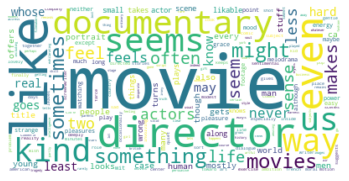

In [54]:
# make a word cloud for top tokens
top_counter = top_sample - regular_sample
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(top_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#https://www.datacamp.com/community/tutorials/wordcloud-python

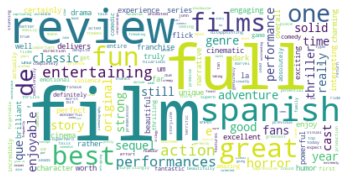

In [55]:
# make a word cloud for regular tokens
regular_counter = regular_sample - top_sample
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(regular_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()